In [2]:
import sys

PROJECT_ROOT = '/nfs/turbo/coe-chaijy/janeding/regrounding/clip_tl'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
print('PYTHONPATH added:', sys.path[0])


PYTHONPATH added: /nfs/turbo/coe-chaijy/janeding/regrounding/clip_tl


# Load the model

In [3]:
import torch
from vit_prisma.utils.constants import DEVICE
from vit_prisma.utils.tutorial_utils import (
    plot_image,
)


/home/janeding/miniconda3/envs/prisma/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import gc

# clear cache
torch.cuda.empty_cache()
# force garbage collection
gc.collect()

torch.cuda.set_device(0)
DEVICE = torch.device('cuda:0')


In [5]:
DEVICE = 'cuda'

In [6]:
# transcoder list
from src.analysis.utils import *

tc_list = load_all_tc()

2025-08-18 20:05:48 DEBUG:urllib3.connectionpool: Starting new HTTPS connection (1): huggingface.co:443


2025-08-18 20:05:48 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-768-x64-all_patches_0-mlp-96/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-18 20:05:48 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-768-x64-all_patches_0-mlp-96/resolve/main/config.json HTTP/1.1" 307 0
2025-08-18 20:05:48 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-768-x64-all_patches_0-mlp-96/b9ff9647261516e5c7a882f7fd130db702c8ea25/config.json HTTP/1.1" 200 0


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-768-x64-all_patches_0-mlp-96/snapshots/b9ff9647261516e5c7a882f7fd130db702c8ea25/weights.pt...


2025-08-18 20:05:49 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 768}
2025-08-18 20:05:49 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-256-x64-all_patches_1-mlp-94/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-18 20:05:49 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-256-x64-all_patches_1-mlp-94/resolve/main/config.json HTTP/1.1" 307 0
2025-08-18 20:05:49 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-256-x64-all_patches_1-mlp-94/96c293a7299a99fe3d70f1f15498215849f22d96/config.json HTTP/1.1" 200 0
2025-08-18 20:05:49 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 256}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-256-x64-all_patches_1-mlp-94/snapshots/96c293a7299a99fe3d70f1f15498215849f22d96/weights.pt...


2025-08-18 20:05:49 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_2-mlp-93/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-18 20:05:49 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_2-mlp-93/resolve/main/config.json HTTP/1.1" 307 0
2025-08-18 20:05:49 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_2-mlp-93/cfb7ad837b972edfa27c9719de0e9571893dc434/config.json HTTP/1.1" 200 0
2025-08-18 20:05:50 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 1024}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-1024-x64-all_patches_2-mlp-93/snapshots/cfb7ad837b972edfa27c9719de0e9571893dc434/weights.pt...


2025-08-18 20:05:50 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_3-mlp-90/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-18 20:05:50 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_3-mlp-90/resolve/main/config.json HTTP/1.1" 307 0
2025-08-18 20:05:50 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_3-mlp-90/3a169de44e8fa1641a9768aa84f3f99a9edd9828/config.json HTTP/1.1" 200 0
2025-08-18 20:05:50 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 1024}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-1024-x64-all_patches_3-mlp-90/snapshots/3a169de44e8fa1641a9768aa84f3f99a9edd9828/weights.pt...


2025-08-18 20:05:50 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-512-x64-all_patches_4-mlp-76/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-18 20:05:50 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-512-x64-all_patches_4-mlp-76/resolve/main/config.json HTTP/1.1" 307 0
2025-08-18 20:05:50 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-512-x64-all_patches_4-mlp-76/01926c5c792d963b51953bb5922674a484c215a5/config.json HTTP/1.1" 200 0
2025-08-18 20:05:50 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 512}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-512-x64-all_patches_4-mlp-76/snapshots/01926c5c792d963b51953bb5922674a484c215a5/weights.pt...


2025-08-18 20:05:50 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_5-mlp-91/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-18 20:05:50 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_5-mlp-91/resolve/main/config.json HTTP/1.1" 307 0
2025-08-18 20:05:50 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_5-mlp-91/12ebdd11e4e404bb95bbcab991eee795fb8cf66c/config.json HTTP/1.1" 200 0
2025-08-18 20:05:51 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 1024}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-1024-x64-all_patches_5-mlp-91/snapshots/12ebdd11e4e404bb95bbcab991eee795fb8cf66c/weights.pt...


2025-08-18 20:05:51 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_6-mlp-94/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-18 20:05:51 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_6-mlp-94/resolve/main/config.json HTTP/1.1" 307 0
2025-08-18 20:05:51 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_6-mlp-94/d0d722d64076e3911bff4b56d92a370543f1ca15/config.json HTTP/1.1" 200 0
2025-08-18 20:05:51 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 1024}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-1024-x64-all_patches_6-mlp-94/snapshots/d0d722d64076e3911bff4b56d92a370543f1ca15/weights.pt...


2025-08-18 20:05:51 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_7-mlp-97/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-18 20:05:51 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_7-mlp-97/resolve/main/config.json HTTP/1.1" 307 0
2025-08-18 20:05:51 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_7-mlp-97/010d526da64705bae8b61f1c6b66617a2ecb69f8/config.json HTTP/1.1" 200 0
2025-08-18 20:05:51 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 1024}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-1024-x64-all_patches_7-mlp-97/snapshots/010d526da64705bae8b61f1c6b66617a2ecb69f8/weights.pt...


2025-08-18 20:05:51 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_8-mlp-98/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-18 20:05:52 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_8-mlp-98/resolve/main/config.json HTTP/1.1" 307 0
2025-08-18 20:05:52 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_8-mlp-98/43d0de77b2a27e664be61a74548d30a826db26fe/config.json HTTP/1.1" 200 0
2025-08-18 20:05:52 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 1024}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-1024-x64-all_patches_8-mlp-98/snapshots/43d0de77b2a27e664be61a74548d30a826db26fe/weights.pt...


2025-08-18 20:05:52 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_9-mlp-98/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-18 20:05:52 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_9-mlp-98/resolve/main/config.json HTTP/1.1" 307 0
2025-08-18 20:05:52 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_9-mlp-98/6f57a523ab849e1b5544b94572d539da7c30cbdb/config.json HTTP/1.1" 200 0
2025-08-18 20:05:52 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 1024}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-1024-x64-all_patches_9-mlp-98/snapshots/6f57a523ab849e1b5544b94572d539da7c30cbdb/weights.pt...


2025-08-18 20:05:52 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_10-mlp-97/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-18 20:05:52 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_10-mlp-97/resolve/main/config.json HTTP/1.1" 307 0
2025-08-18 20:05:52 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_10-mlp-97/a083216cc058dad1ea74a5b375c6c152b76ca6ad/config.json HTTP/1.1" 200 0
2025-08-18 20:05:53 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 1024}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-1024-x64-all_patches_10-mlp-97/snapshots/a083216cc058dad1ea74a5b375c6c152b76ca6ad/weights.pt...


In [7]:
# HookedViT
from vit_prisma.models.model_loader import load_hooked_model
from vit_prisma.utils.enums import ModelType

model_name = tc_list[0].cfg.model_name
hookedvit = load_hooked_model(model_name, model_type=ModelType.VISION)
hookedvit = hookedvit.to(DEVICE)

2025-08-18 20:05:53 INFO:root: Model 'open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K' is supported and passes tests.
2025-08-18 20:05:53 INFO:root: model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
2025-08-18 20:05:53 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K/resolve/main/open_clip_config.json HTTP/1.1" 307 0
2025-08-18 20:05:53 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K/f0e2ffa09cbadab3db6a261ec1ec56407ce42912/open_clip_config.json HTTP/1.1" 200 0
2025-08-18 20:05:53 INFO:root: HookedViTConfig(n_layers=12, d_model=768, d_head=64, d_mlp=3072, model_name='open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K', use_cls_token=True, n_heads=12, activation_name='gelu', d_vocab=-1, eps=1e-05, use_attn_result=False, use_attn_scale=True, use_split_qkv_input=False, use_hook_mlp_in=False, use_attn_in=False, use_lo

In [8]:
# check: predict label to be 'chemistry'
# load the labels of a big word list for the check, but not the later ablation
import pandas as pd

file_path = '/nfs/turbo/coe-chaijy/janeding/regrounding/MyTC_bert/data/concrete_visual_vocabulary.csv'
labels = pd.read_csv(file_path)

labels = labels.dropna(subset=['word'])
labels['word'] = labels['word'].astype(str).str.lower().str.strip()
labels = labels[labels['word'].ne('')]
labels = labels[labels['word'].ne('nan')]

# turn into dict
label_dict = {
    row['word']: {
        'concreteness': row['concreteness'],
        'imageability': row['imageability'],
    }
    for _, row in labels.iterrows()
}

In [9]:
# load the CLIP text transformer encoder model

import open_clip
import torch
from open_clip.model import text_global_pool
from torch import nn


def name_from_hf(model_name):
    """return model name from huggingface"""
    return model_name.replace('open-clip:', 'hf-hub:')


class OpenCLIPTextOnly(nn.Module):
    def __init__(self, clip):
        super().__init__()
        # only keep the text part of the model
        self.vocab_size = clip.vocab_size
        self.token_embedding = clip.token_embedding
        self.positional_embedding = clip.positional_embedding
        self.transformer = clip.transformer
        self.ln_final = clip.ln_final
        self.text_projection = clip.text_projection
        self.attn_mask = clip.attn_mask
        self.text_pool_type = clip.text_pool_type
        self.text_eos_id = getattr(clip, 'text_eos_id', None)
        # self.register_buffer('attn_mask', self.attn_mask, persistent=False)

    @torch.no_grad()
    def encode_text(self, text, normalize=False):
        cast_dtype = self.transformer.get_cast_dtype()
        x = self.token_embedding(text).to(cast_dtype)  # [B, L, D]
        x = x + self.positional_embedding.to(cast_dtype)
        x = self.transformer(
            x, attn_mask=self.attn_mask
        )  # transformer(width=D)
        x = self.ln_final(x)
        x = text_global_pool(x, text, self.text_pool_type)
        if self.text_projection is not None:
            x = (
                self.text_projection(x)
                if isinstance(self.text_projection, nn.Linear)
                else x @ self.text_projection
            )
        return nn.functional.normalize(x, dim=-1) if normalize else x

    def forward(self, text):
        return self.encode_text(text, normalize=True)


tmp_model, _, _ = open_clip.create_model_and_transforms(
    name_from_hf(tc_list[0].cfg.model_name),
)
tmp_model.to(DEVICE)
tmp_model.eval()

tokenizer = open_clip.get_tokenizer(name_from_hf(tc_list[0].cfg.model_name))

# free up visual tower memory (optional)
if hasattr(tmp_model, 'visual'):
    delattr(tmp_model, 'visual')
    torch.cuda.empty_cache()

text_model = OpenCLIPTextOnly(tmp_model).eval().to(DEVICE)
# text_model.forward(input_ids) or text_model.encode_text(input_ids, normalize=True)

2025-08-18 20:05:55 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K/resolve/main/open_clip_model.safetensors HTTP/1.1" 302 0
2025-08-18 20:05:55 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K/resolve/main/open_clip_config.json HTTP/1.1" 307 0
2025-08-18 20:05:55 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K/f0e2ffa09cbadab3db6a261ec1ec56407ce42912/open_clip_config.json HTTP/1.1" 200 0
2025-08-18 20:05:55 INFO:root: Loaded hf-hub:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K model config.
2025-08-18 20:05:56 INFO:root: Loading pretrained hf-hub:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K weights (/home/janeding/.cache/huggingface/hub/models--laion--CLIP-ViT-B-32-DataComp.XL-s13B-b90K/snapshots/f0e2ffa09cbadab3db6a261ec1ec56407ce42912/open_clip_model.safetensors).
2025-08-18 20:05:56 DEBUG:urlli

In [10]:
text_model


OpenCLIPTextOnly(
  (token_embedding): Embedding(49408, 512)
  (transformer): Transformer(
    (resblocks): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (ls_1): Identity()
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=512, out_features=2048, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=2048, out_features=512, bias=True)
        )
        (ls_2): Identity()
      )
    )
  )
  (ln_final): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)

2025-08-18 20:05:56 DEBUG:PIL.PngImagePlugin: STREAM b'IHDR' 16 13
2025-08-18 20:05:56 DEBUG:PIL.PngImagePlugin: STREAM b'sBIT' 41 4
2025-08-18 20:05:56 DEBUG:PIL.PngImagePlugin: b'sBIT' 41 4 (unknown)
2025-08-18 20:05:56 DEBUG:PIL.PngImagePlugin: STREAM b'pHYs' 57 9
2025-08-18 20:05:56 DEBUG:PIL.PngImagePlugin: STREAM b'tEXt' 78 25
2025-08-18 20:05:56 DEBUG:PIL.PngImagePlugin: STREAM b'IDAT' 115 8192
2025-08-18 20:05:56 DEBUG:matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-18 20:05:56 DEBUG:matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-18 20:05:56 DEBUG:matplotlib.font_manager: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-08-18 20:05:56 DEBUG:matplotlib.font_manager: findfont: score(FontEntry(fname='/home/janeding/miniconda3/envs/prisma/lib/python3.13/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='Dej

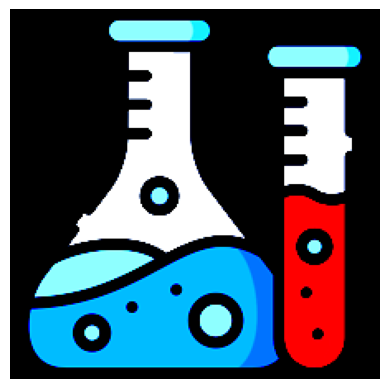

In [11]:
# image

from PIL import Image
from vit_prisma.transforms import get_clip_val_transforms

# img_path = '/nfs/turbo/coe-chaijy/janeding/example_images/smiling-face.png'
img_path = '/nfs/turbo/coe-chaijy/janeding/regrounding/clip_tl/example_images/flask.png'
gt_label = 'chemistry'
img = Image.open(img_path).convert()  # Ensure it's 3 channels
transforms = get_clip_val_transforms()
img_tensor = transforms(img)
plot_image(img_tensor.detach().cpu(), unstandardise=False)

In [12]:
# now try a smaller label set
from custom_labels import final_labels

# final_labels.append('cat')
smaller_text_tokens = open_clip.tokenize(final_labels)

final_labels

['inadequate',
 'holler',
 'acid',
 'chemical',
 'disqualify',
 'unobjectionably',
 'worming',
 'clergyman',
 'urgency',
 'edged',
 'wasting',
 'autocratic',
 'advancing',
 'snip',
 'hardware',
 'buffet',
 'which',
 'heating',
 'enema',
 'scientist',
 'backlight',
 'funk',
 'world',
 'visceral',
 'inclusiveness',
 'mixture',
 'flask',
 'proficiently',
 'glassware',
 'analysis',
 'governing',
 'forgotten',
 'education',
 'much',
 'long haul',
 'corrupt',
 'sporting',
 'mainsheet',
 'funneled',
 'depersonalization',
 'observation',
 'associational',
 'solvent',
 'consultancy',
 'classes',
 'unspoiled',
 'premonition',
 'twit',
 'barbed wire',
 'disorganize',
 'lordship',
 'indulgency',
 'heliport',
 'prehistory',
 'hockey stick',
 'proofreading',
 'scamper',
 'secret',
 'irreproachability',
 'pinecone',
 'hardhead',
 'souring',
 'knelt',
 'unventilated',
 'research tools',
 'albacore',
 'sample',
 'innovation',
 'brewery',
 'caricaturist',
 'cuff',
 'cellar',
 'pintsize',
 'umbilical cor

In [13]:
CHUNK_SIZE = 512

with torch.no_grad():
    image_input = img_tensor.unsqueeze(0).to(DEVICE)
    vis_out, cache = hookedvit.run_with_cache(image_input)
    image_features = vis_out.to(DEVICE)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    text_feats_out = []
    for i in range(0, len(smaller_text_tokens), CHUNK_SIZE):
        chunk = smaller_text_tokens[i : i + CHUNK_SIZE].to(
            DEVICE, non_blocking=True
        )
        feats = text_model.encode_text(chunk)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        text_feats_out.append(feats.cpu())
    text_features = torch.cat(text_feats_out).to(DEVICE)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_idx = text_probs.squeeze().topk(50)
for i, (prob, idx) in enumerate(zip(top_probs, top_idx)):
    print(f'{i + 1}. label: {final_labels[idx]:<20} | prob: {prob.item():.4f}')


1. label: test tube            | prob: 0.4590
2. label: science equipment    | prob: 0.0981
3. label: chemistry            | prob: 0.0883
4. label: chemical             | prob: 0.0811
5. label: laboratory bottle    | prob: 0.0781
6. label: reagent              | prob: 0.0348
7. label: beaker               | prob: 0.0329
8. label: research tools       | prob: 0.0326
9. label: laboratory           | prob: 0.0241
10. label: titration            | prob: 0.0214
11. label: science              | prob: 0.0162
12. label: graduated tube       | prob: 0.0132
13. label: distillation         | prob: 0.0066
14. label: experiment           | prob: 0.0032
15. label: vial                 | prob: 0.0020
16. label: solvent              | prob: 0.0010
17. label: flask                | prob: 0.0010
18. label: pipette              | prob: 0.0009
19. label: liquid               | prob: 0.0008
20. label: scientist            | prob: 0.0006
21. label: biologist            | prob: 0.0005
22. label: experimenta

In [14]:
def get_text_features(text_model, labels, chunk_size=1024, device=DEVICE):
    prompts = [f'a photo of a {l}' for l in labels]
    label_tokens = open_clip.tokenize(prompts)  # [N, 77] on CPU

    text_feats_out = []
    for i in range(0, len(label_tokens), chunk_size):
        chunk = label_tokens[i : i + chunk_size].to(device, non_blocking=True)
        feats = text_model.encode_text(chunk)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        text_feats_out.append(feats.cpu())
    text_features = torch.cat(text_feats_out).to(device)
    return text_features

In [15]:
text_features = get_text_features(
    text_model, final_labels, chunk_size=1024, device=DEVICE
)

In [16]:
import pprint

pprint.pprint(tc_list[0].cfg)

VisionModelSAERunnerConfig(model_class_name='HookedViT',
                           model_name='open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K',
                           vit_model_cfg=None,
                           model_path=None,
                           hook_point_layer=0,
                           layer_subtype='ln2.hook_normalized',
                           hook_point_head_index=None,
                           context_size=50,
                           use_cached_activations=False,
                           use_patches_only=False,
                           cached_activations_path='activations/_network_scratch_s_sonia.joseph_datasets_kaggle_datasets/open-clip:laion_CLIP-ViT-B-32-DataComp.XL-s13B-b90K/blocks.9.ln2.hook_normalized',
                           image_size=224,
                           architecture='standard',
                           b_dec_init_method='geometric_median',
                           expansion_factor=64,
                           fr

In [17]:
import pprint

pprint.pprint(hookedvit.cfg)

HookedViTConfig(n_layers=12,
                d_model=768,
                d_head=64,
                d_mlp=3072,
                model_name='open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K',
                use_cls_token=True,
                n_heads=12,
                activation_name='gelu',
                d_vocab=-1,
                eps=1e-05,
                use_attn_result=False,
                use_attn_scale=True,
                use_split_qkv_input=False,
                use_hook_mlp_in=False,
                use_attn_in=False,
                use_local_attn=False,
                original_architecture=None,
                from_checkpoint=False,
                checkpoint_index=None,
                checkpoint_label_type=None,
                checkpoint_value=None,
                tokenizer_name=None,
                window_size=None,
                attn_types=None,
                init_mode='gpt2',
                normalization_type='LN',
                normalize_outpu

In [18]:
# load hookedsaevit
from vit_prisma.models.base_vit import HookedTranscoderViT

hookedvit.__class__ = HookedTranscoderViT
hookedvit.mlp_to_transcoders = {}
hookedvit._original_mlps = {}

hookedsaevit = hookedvit

print(f'Original hookedvit object is now of type: {type(hookedvit)}')
print(f'hookedsaevit object is of type: {type(hookedsaevit)}')


Original hookedvit object is now of type: <class 'vit_prisma.models.base_vit.HookedTranscoderViT'>
hookedsaevit object is of type: <class 'vit_prisma.models.base_vit.HookedTranscoderViT'>


In [19]:
import pprint

pprint.pprint(tc_list[10].cfg)

VisionModelSAERunnerConfig(model_class_name='HookedViT',
                           model_name='open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K',
                           vit_model_cfg=None,
                           model_path=None,
                           hook_point_layer=10,
                           layer_subtype='ln2.hook_normalized',
                           hook_point_head_index=None,
                           context_size=50,
                           use_cached_activations=False,
                           use_patches_only=False,
                           cached_activations_path='activations/_network_scratch_s_sonia.joseph_datasets_kaggle_datasets/open-clip:laion_CLIP-ViT-B-32-DataComp.XL-s13B-b90K/blocks.9.ln2.hook_normalized',
                           image_size=224,
                           architecture='standard',
                           b_dec_init_method='geometric_median',
                           expansion_factor=64,
                           f

In [122]:
def test_img_input(
    hooked_vis_model: HookedTranscoderViT,
    transcoders: list[SparseAutoencoder],
    fwd_hooks,
    img_tensor: torch.Tensor,
    text_features: torch.Tensor,
    labels: list[str],
    device=DEVICE,
):
    with torch.no_grad():
        img_tensor = img_tensor.unsqueeze(0).to(DEVICE)
        vis_out = hooked_vis_model.run_with_hooks_with_transcoders(
            img_tensor,
            transcoders=transcoders,
            fwd_hooks=fwd_hooks,
            bwd_hooks=[],
        )
        image_features = vis_out.to(device)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        top_probs, top_idx = text_probs.squeeze().topk(20)

    for i, (prob, idx) in enumerate(zip(top_probs, top_idx)):
        print(f'{i + 1}. label: {labels[idx]:<20} | prob: {prob.item():.4f}')


In [ ]:
def get_top_activations(
    hooked_vis_model: HookedTranscoderViT,
    transcoder: SparseAutoencoder,
    img_tensor: torch.Tensor,
    text_features: torch.Tensor,
    labels: list[str],
):
    top_act_ids: dict[int, list[int]] = {}
    hook_layer = transcoder.cfg.hook_point_layer
    hook_point = f'blocks.{hook_layer}.mlp.hook_hidden_post'

    def get_top_activations_hook(
        feature_activations: torch.Tensor,
        hook,
    ):
        nonzero_indices = torch.nonzero(feature_activations, as_tuple=False)
        if nonzero_indices.numel() > 0:
            feature_ids = nonzero_indices[:, -1]
            sorted_feature_ids = sorted(feature_ids.detach().unique().tolist())
            top_act_ids[hook_layer] = sorted_feature_ids
        else:
            top_act_ids[hook_layer] = []

    with torch.no_grad():
        img_tensor = img_tensor.unsqueeze(0).to(DEVICE)
        vis_out = hooked_vis_model.run_with_hooks_with_transcoders(
            img_tensor,
            transcoders=[transcoder],
            fwd_hooks=[(hook_point, get_top_activations_hook)],
            bwd_hooks=[],
            reset_hooks_end=True,
        )
        image_features = vis_out.to(img_tensor.device)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        top_probs, top_idx = text_probs.squeeze().topk(20)

    for i, (prob, idx) in enumerate(zip(top_probs, top_idx)):
        print(f'{i + 1}. label: {labels[idx]:<20} | prob: {prob.item():.4f}')

    return top_act_ids[hook_layer], top_probs, top_idx

In [119]:
def pick_noise_level(
    model: nn.Module,
    embedding_layer: str,
    std_multiplier: float = 3,
) -> float:
    """
    Pick a noise level to corrupt the input text with, such that the
    noise is a multiplier of the stdev of the token embeddings.
    """
    with torch.no_grad():
        embedding_weights = cast(
            torch.Tensor, get_module(model, embedding_layer).weight
        )
        noise_level_std = embedding_weights.std().item()
    return std_multiplier * noise_level_std

In [23]:
import numpy as np


def _get_consistent_noise(
    self, sample_num: int, subj_len: int, layer_size: int
) -> np.typing.NDArray[np.float64]:
    """
    Returns a numpy array of noise for a given sample number and shape, which is consistent for each combination of inputs
    """
    cache_key = (sample_num, subj_len, layer_size)
    if cache_key not in self._noise_cache:
        prng = np.random.RandomState(self.random_seed)
        self._noise_cache[cache_key] = prng.randn(
            self.samples_per_patch, subj_len, layer_size
        )[sample_num]
    return self._noise_cache[cache_key]

In [ ]:
from functools import partial


def zero_ablate_feature_hook(
    feature_activations, hook, feature_ids, position=None
):
    if position is None:
        feature_activations[:, :, feature_ids] = 0
    else:
        feature_activations[:, position, feature_ids] = 0

    return feature_activations


def gaussian_ablate_feature_hook(
    feature_activations,
    hook,
    feature_ids,
    position=None,
    sigma=3.0,
    # n_repeats=10,
    mode='add',
    match_scale=True,
    eps=1e-6,
    seed=42,
) -> torch.Tensor:
    """Add gaussian noise to the feature activations.

    Args:
        - feature_activations: The feature activations after the activation
        function in transcoder.
        - hook: The hook to ablate, should be after the activation function in
        transcoder.
        - feature_ids: The feature ids to ablate. If None, all features are
        ablated.
        - position: The token position to ablate. If None, all positions are
        ablated.
        - sigma: The standard deviation of the gaussian noise. In the ROME
        paper, they use 3.0, and point out that the noise level should be large
        enough to make an effect.
        - mode: The mode to add the gaussian noise. Can be 'add' or 'replace'.
        - match_scale: Whether to match the scale of the feature activations.
            Reccomended to be True since the feature activations can vary.
        - eps: The epsilon to avoid division by zero.
        - seed: The seed to generate the gaussian noise.

    Returns:
        The feature activations after the gaussian noise is added.
    """

    if position is None:
        target_slice = (slice(None), slice(None), feature_ids)
    else:
        target_slice = (slice(None), position, feature_ids)

    target = feature_activations[target_slice]

    # print(f'target shape: {target.shape}')
    # print(f'target sum: {target.sum().item()}')
    # print(f'target max: {target.max().item()}')
    # print(f'target min: {target.min().item()}')
    # print(f'feature_activations shape: {feature_activations.shape}')
    # print(f'feature_activations sum: {feature_activations.sum().item()}')
    # print(f'feature_activations max: {feature_activations.max().item()}')
    # print(f'feature_ids range: {min(feature_ids)} to {max(feature_ids)}')

    if match_scale:
        dims = (0, 1) if target.dim() == 3 else (0,)
        # dims = tuple(range(target.dim()))
        std = (
            target.detach()
            # feature_activations.detach()
            .float()
            .std(dim=dims, keepdim=True, unbiased=False)
            .clamp_min(eps)
            .to(target.device)
        )
        noise_std = sigma * std
    else:
        noise_std = sigma

    # print(f'noise_std: {noise_std}')

    # shape_full = (n_repeats, *target.shape)

    # set seed for reproducibility
    current_rng_state = torch.get_rng_state()
    torch.manual_seed(seed)
    noise = torch.randn_like(target).mul_(noise_std)  # type: ignore
    torch.set_rng_state(current_rng_state)

    # noise = (
    #     torch.randn(shape_full, device=target.device, dtype=target.dtype)
    #     .mul_(noise_std)
    #     .sum(dim=0)
    # )

    # see how much element in target are nonzero
    print(f'{target.nonzero().numel()} / {target.numel()} elements are nonzero')

    if mode == 'add':
        target.add_(noise)

    elif mode == 'replace':
        target.copy_(noise)

    feature_activations[target_slice] = target

    return feature_activations


def _test_with_ablation(
    model,
    transcoder,
    type,
    img_tensor,
    text_features,
    ablation_features,
    labels,
    **ablation_kwargs,
):
    hook_layer = transcoder.cfg.hook_point_layer
    hook_point = f'blocks.{hook_layer}.mlp.hook_hidden_post'
    if type == 'zero':
        ablation_hook = partial(
            zero_ablate_feature_hook,
            feature_ids=ablation_features,
            **ablation_kwargs,
        )
    elif type == 'gaussian':
        ablation_hook = partial(
            gaussian_ablate_feature_hook,
            feature_ids=ablation_features,
            **ablation_kwargs,
        )
    else:
        raise ValueError(f'Invalid ablation type: {type}')

    test_img_input(
        model,
        transcoder,
        [(hook_point, ablation_hook)],
        img_tensor,
        text_features,
        labels,
    )


In [155]:
transcoder = tc_list[0]

transcoder.eval()
hookedsaevit.eval()
top_act_ids, top_probs, top_idx = get_top_activations(
    hookedsaevit,
    transcoder,
    img_tensor,  # type: ignore
    text_features,
    final_labels,
)

top_act_ids

1. label: chemistry            | prob: 0.1975
2. label: laboratory bottle    | prob: 0.1142
3. label: reagent              | prob: 0.1133
4. label: chemical             | prob: 0.1005
5. label: science              | prob: 0.0871
6. label: research tools       | prob: 0.0841
7. label: reaction             | prob: 0.0326
8. label: liquid               | prob: 0.0288
9. label: titration            | prob: 0.0270
10. label: test tube            | prob: 0.0253
11. label: experiment           | prob: 0.0253
12. label: solvent              | prob: 0.0232
13. label: science equipment    | prob: 0.0218
14. label: experimentation      | prob: 0.0163
15. label: research             | prob: 0.0136
16. label: solution             | prob: 0.0123
17. label: flask                | prob: 0.0108
18. label: ethicality           | prob: 0.0100
19. label: beaker               | prob: 0.0079
20. label: vial                 | prob: 0.0059


[23,
 88,
 163,
 225,
 323,
 343,
 366,
 419,
 435,
 450,
 465,
 476,
 485,
 492,
 506,
 554,
 576,
 598,
 759,
 807,
 874,
 889,
 993,
 998,
 1011,
 1023,
 1048,
 1109,
 1174,
 1221,
 1237,
 1262,
 1271,
 1300,
 1301,
 1310,
 1358,
 1379,
 1426,
 1464,
 1498,
 1625,
 1639,
 1723,
 1745,
 1780,
 1793,
 1796,
 1882,
 1899,
 2088,
 2130,
 2159,
 2166,
 2197,
 2216,
 2217,
 2238,
 2245,
 2250,
 2259,
 2261,
 2282,
 2312,
 2360,
 2391,
 2405,
 2413,
 2415,
 2434,
 2436,
 2541,
 2575,
 2618,
 2629,
 2716,
 2725,
 2735,
 2745,
 2768,
 2790,
 2818,
 2822,
 2952,
 2959,
 3017,
 3037,
 3053,
 3062,
 3069,
 3100,
 3133,
 3143,
 3146,
 3149,
 3190,
 3194,
 3198,
 3201,
 3324,
 3399,
 3430,
 3458,
 3547,
 3572,
 3625,
 3695,
 3699,
 3759,
 3789,
 3853,
 3872,
 3887,
 3910,
 3966,
 3978,
 4032,
 4056,
 4080,
 4113,
 4130,
 4133,
 4214,
 4223,
 4228,
 4287,
 4317,
 4330,
 4331,
 4376,
 4377,
 4380,
 4409,
 4410,
 4416,
 4423,
 4487,
 4506,
 4573,
 4580,
 4595,
 4656,
 4669,
 4715,
 4748,
 4782,
 479

In [156]:
# ablation_features = list(range(20000, 40000))
ablation_features = top_act_ids
_test_with_ablation(
    hookedsaevit,
    transcoder,
    'zero',
    img_tensor,
    text_features,
    ablation_features,
    final_labels,
)


1. label: graphic              | prob: 0.0890
2. label: uptempo              | prob: 0.0434
3. label: ethicality           | prob: 0.0328
4. label: immorality           | prob: 0.0275
5. label: solution             | prob: 0.0270
6. label: misappropriation     | prob: 0.0268
7. label: chemistry            | prob: 0.0265
8. label: experimentation      | prob: 0.0253
9. label: disreputability      | prob: 0.0247
10. label: which                | prob: 0.0219
11. label: research             | prob: 0.0194
12. label: reaction             | prob: 0.0188
13. label: inclusiveness        | prob: 0.0188
14. label: autocratic           | prob: 0.0181
15. label: science              | prob: 0.0165
16. label: compound             | prob: 0.0159
17. label: research tools       | prob: 0.0153
18. label: unpremeditatedly     | prob: 0.0148
19. label: antisocial           | prob: 0.0143
20. label: equivalence          | prob: 0.0134


In [167]:
_test_with_ablation(
    hookedsaevit,
    transcoder,
    'gaussian',
    img_tensor,
    text_features,
    ablation_features,
    labels=final_labels,
    sigma=2.0,
    match_scale=True,
    seed=42,  # Change seed for different noise
)

97017 / 70950 elements are nonzero
1. label: graphic              | prob: 0.0941
2. label: experimentation      | prob: 0.0885
3. label: misappropriation     | prob: 0.0539
4. label: technology           | prob: 0.0369
5. label: which                | prob: 0.0321
6. label: inconstantly         | prob: 0.0299
7. label: ethicality           | prob: 0.0271
8. label: twit                 | prob: 0.0210
9. label: candidness           | prob: 0.0191
10. label: acid                 | prob: 0.0188
11. label: satisfied            | prob: 0.0167
12. label: funneled             | prob: 0.0165
13. label: uptempo              | prob: 0.0161
14. label: hardware             | prob: 0.0158
15. label: pintsize             | prob: 0.0151
16. label: regenerate           | prob: 0.0150
17. label: knowledge            | prob: 0.0150
18. label: reaction             | prob: 0.0147
19. label: antisocial           | prob: 0.0146
20. label: expletive            | prob: 0.0141


In [ ]:
import random
from typing import Any

import numpy as np
import torch


class AblationExperimentRunner:
    """
    Encapsulates the logic for running a suite of ablation experiments
    on a HookedTranscoderViT model, ensuring comparability between different
    ablation methods by using a feature injection technique. Will run 4 types of
    forward passes:
    - Original CLIP baseline
    - Transcoder baseline
    - Zero Ablation
    - Gaussian Noise Ablation (with n_gn_samples samples)

    The feature activations from the transcoder baseline are used to inject
    zero and Gaussian noise into the model for apple-to-apple comparison.
    """

    def __init__(
        self,
        model: 'HookedTranscoderViT',
        transcoders: list[SparseAutoencoder],
        img_tensor: torch.Tensor,
        labels: list[str],
        text_features: torch.Tensor,
        device='cuda',
    ):
        self.model = model
        self.transcoders = {tc.cfg.hook_point_layer: tc for tc in transcoders}
        self.img_tensor = img_tensor.to(device)
        self.labels = labels
        self.text_features = text_features.to(device)
        self.device = device
        self.gn_generator = torch.Generator(device=device)
        self.results: dict[str, Any] = {}

    @staticmethod
    def set_seeds(seed: int):
        """Sets random seeds for reproducibility."""
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    def _format_results(self, probs, idxs) -> dict[str, float]:
        """Formats model output into a dictionary."""
        return {
            self.labels[idx.item()]: prob.item()
            for prob, idx in zip(probs, idxs)
        }

    def _run_forward_pass(
        self, transcoders_to_use, fwd_hooks
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """Generic helper to run the model and get top predictions."""
        with torch.no_grad():
            img_input = self.img_tensor.unsqueeze(0).to(self.device)
            vis_out = self.model.run_with_hooks_with_transcoders(
                img_input,
                transcoders=transcoders_to_use,
                fwd_hooks=fwd_hooks,
                bwd_hooks=[],
                reset_hooks_end=True,
            )
            image_features = vis_out.to(self.device)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_probs = (
                100.0 * image_features @ self.text_features.T
            ).softmax(dim=-1)
            top_probs, top_idx = text_probs.squeeze().topk(20)
        return top_probs, top_idx

    def run_original_clip_baseline(self, seed: int):
        """Runs the baseline CLIP model without any transcoders."""
        print(f'--- [Seed {seed}] Running Original CLIP Baseline ---')
        self.set_seeds(seed)
        self.model.eval()
        # This resets all transcoders, restoring the original MLP layers
        self.model.reset_transcoders()
        top_probs, top_idx = self._run_forward_pass(
            transcoders_to_use=[], fwd_hooks=[]
        )
        self.results[f'original_clip_seed{seed}'] = self._format_results(
            top_probs, top_idx
        )
        print('Baseline Done.')

    def run_ablation_suite(
        self,
        layer_idx: int,
        ablation_feature_ids: list[int],
        seed: int,
        n_gn_samples: int = 10,
        sigma: float = 1.0,
    ):
        """
        Runs the full suite of experiments for a single layer and seed.
        1. Captures baseline activations with the transcoder.
        2. Runs zero and Gaussian noise ablations by injecting modified versions
           of the captured activations.

        Args:
            layer_idx: The layer index to run the experiments on.
            n_gn_samples: The number of Gaussian noise samples to run.
            sigma: The standard deviation of the Gaussian noise.
        """
        self.set_seeds(seed)
        self.model.eval()

        if layer_idx not in self.transcoders:
            raise ValueError(f'No transcoder found for layer {layer_idx}')
        transcoder = self.transcoders[layer_idx]
        hook_point = f'blocks.{layer_idx}.mlp.hook_hidden_post'

        # --- Step 1: Capture baseline activations & get baseline transcoder results ---
        print(
            f'\n--- [Seed {seed}] Running Transcoder Baseline & Capturing Activations for L{layer_idx} ---'
        )
        captured_activations = None

        def capture_hook(activations, hook):
            nonlocal captured_activations
            captured_activations = activations.clone().detach()

        top_probs, top_idx = self._run_forward_pass(
            transcoders_to_use=[transcoder],
            fwd_hooks=[(hook_point, capture_hook)],
        )
        if captured_activations is None:
            raise RuntimeError('Failed to capture activations.')
        self.results[f'transcoder_L{layer_idx}_seed{seed}'] = (
            self._format_results(top_probs, top_idx)
        )
        print('Activations captured.')

        # --- Step 2: Run ablation experiments using injection ---

        # 2a. Zero Ablation
        print(f'--- [Seed {seed}] Running Zero Ablation for L{layer_idx} ---')

        def inject_hook_zero_ablation(activations, hook):
            modified_activations = captured_activations.clone()
            return zero_ablate_feature_hook(
                modified_activations, hook, feature_ids=ablation_feature_ids
            )

        top_probs, top_idx = self._run_forward_pass(
            transcoders_to_use=[transcoder],
            fwd_hooks=[(hook_point, inject_hook_zero_ablation)],
        )
        self.results[f'zero_ablation_L{layer_idx}_seed{seed}'] = (
            self._format_results(top_probs, top_idx)
        )
        print('Zero Ablation Done.')

        # 2b. Gaussian Noise Ablation
        print(
            f'--- [Seed {seed}] Running Gaussian Noise Ablation for L{layer_idx} ({n_gn_samples} samples) ---'
        )
        gn_results_list = []
        for i in range(n_gn_samples):
            gn_seed = seed * 100 + i

            def inject_hook_gn_ablation(activations, hook):
                modified_activations = captured_activations.clone()
                return gaussian_ablate_feature_hook(
                    modified_activations,
                    hook,
                    feature_ids=ablation_feature_ids,
                    sigma=sigma,
                    match_scale=True,
                    seed=gn_seed,
                )

            top_probs, top_idx = self._run_forward_pass(
                transcoders_to_use=[transcoder],
                fwd_hooks=[(hook_point, inject_hook_gn_ablation)],
            )
            gn_results_list.append(self._format_results(top_probs, top_idx))

        self.results[f'gn_ablation_L{layer_idx}_seed{seed}'] = gn_results_list
        print('GN Ablation Done.')


In [186]:
runner = AblationExperimentRunner(
    model=hookedsaevit,
    transcoders=[transcoder],
    img_tensor=img_tensor,
    text_features=text_features,
    labels=final_labels,
    device='cuda',
)

In [187]:
transcoder = tc_list[0]

top_feature_ids, _, _ = get_top_activations(
    hookedsaevit,
    transcoder,
    img_tensor,
    text_features,
    final_labels,
)


1. label: chemistry            | prob: 0.1975
2. label: laboratory bottle    | prob: 0.1142
3. label: reagent              | prob: 0.1133
4. label: chemical             | prob: 0.1005
5. label: science              | prob: 0.0871
6. label: research tools       | prob: 0.0841
7. label: reaction             | prob: 0.0326
8. label: liquid               | prob: 0.0288
9. label: titration            | prob: 0.0270
10. label: test tube            | prob: 0.0253
11. label: experiment           | prob: 0.0253
12. label: solvent              | prob: 0.0232
13. label: science equipment    | prob: 0.0218
14. label: experimentation      | prob: 0.0163
15. label: research             | prob: 0.0136
16. label: solution             | prob: 0.0123
17. label: flask                | prob: 0.0108
18. label: ethicality           | prob: 0.0100
19. label: beaker               | prob: 0.0079
20. label: vial                 | prob: 0.0059


In [ ]:
SEED = 42
LAYER_TO_TEST = 0  # Example: test the first transcoder
N_GN_SAMPLES = 10
SIGMA = 2.0


In [188]:
runner.run_original_clip_baseline(seed=SEED)
runner.run_ablation_suite(
    layer_idx=LAYER_TO_TEST,
    ablation_feature_ids=top_feature_ids,
    seed=SEED,
    n_gn_samples=N_GN_SAMPLES,
    sigma=SIGMA,
)

--- [Seed 42] Running Original CLIP Baseline ---
Baseline Done.

--- [Seed 42] Running Transcoder Baseline & Capturing Activations for L0 ---
Activations captured.
--- [Seed 42] Running Zero Ablation for L0 ---
Zero Ablation Done.
--- [Seed 42] Running Gaussian Noise Ablation for L0 (10 samples) ---
97017 / 70950 elements are nonzero
97017 / 70950 elements are nonzero
97017 / 70950 elements are nonzero
97017 / 70950 elements are nonzero
97017 / 70950 elements are nonzero
97017 / 70950 elements are nonzero
97017 / 70950 elements are nonzero
97017 / 70950 elements are nonzero
97017 / 70950 elements are nonzero
97017 / 70950 elements are nonzero
GN Ablation Done.


In [189]:
import pprint

pprint.pprint(runner.results)

{'gn_ablation_L0_seed42': [{'candidness': 0.016439052298665047,
                            'disorganize': 0.012279752641916275,
                            'electrostatics': 0.021551677957177162,
                            'engagingness': 0.010660474188625813,
                            'equivalence': 0.010657505132257938,
                            'ethicality': 0.04339324310421944,
                            'experimentation': 0.125112846493721,
                            'funneled': 0.010829261504113674,
                            'graphic': 0.13300321996212006,
                            'inconstantly': 0.015027370303869247,
                            'misappropriation': 0.029279856011271477,
                            'much': 0.010729238390922546,
                            'reaction': 0.011629119515419006,
                            'regenerate': 0.019415581598877907,
                            'science': 0.012716084718704224,
                            'sound': 0.0